<b>Dans ce notebook on nettoie le dataset sur la base des éléments décrits par le notebook Describe_Dataset</b>

# Table of contents
1. [Load du dataset](#load)
2. [Mise à l'écart des données US](#purge_us)
3. [Mise à l'écart des features redondantes](#purge_redund)
4. [Mise à l'écart des features 100% NaN](#purge_nan)
5. [Regroupement des PNNS](#pnns)
6. [Traitement des outliers](#outliers) 
7. [Imputations](#imputations)

    7.1 [High density features](#impute_high_density)
    
    7.2 [Mid density features](#impute_mid_density)
   


<b  style="background-color:tomato;font-size:14px;">1. LOAD DU DATASET<b>
    <a id="load"></a>   

In [82]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

try:
    del data
except:
    dummy=1

#On ne prend qu'un échantillon du fait des limitations mémoire de la machine
data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',nrows=300000)

/home/alpro/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,12,18,19,20,21,22,26,27,28,30,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<b  style="background-color:tomato;font-size:14px;">2. MISE A L'ECART DES DONNEES US<b>
    <a id="load"></a>  

In [83]:
us_to_remove = data[data['countries_tags']=="en:united-states"].index
print('data shape before removal: ' + str(data.shape))
data.drop(us_to_remove, inplace = True)
print('data shape after removal: ' + str(data.shape))

data shape before removal: (300000, 183)
data shape after removal: (85306, 183)


<b  style="background-color:tomato;font-size:14px;">3. MISE A L'ECART DES FEATURES REDONDANTES<b>
    <a id="load"></a>  

In [84]:
columns_to_remove = []
for s in data.columns:
    if "_tags" in s: 
        t = s.replace('_tags', '')
        u = s.replace('_tags', '_en')
        print("{:<20} 'no suffix' -> {} ; '_en' suffix -> {}".format(s,t in data.columns, u in data.columns))
        if t in data.columns: columns_to_remove.append(t)
        if u in data.columns: columns_to_remove.append(u)
print('data shape before removal: ' + str(data.shape))
data.drop(columns_to_remove, axis = 1, inplace = True)
print('data shape after removal: ' + str(data.shape))

packaging_tags       'no suffix' -> True ; '_en' suffix -> False
brands_tags          'no suffix' -> True ; '_en' suffix -> False
categories_tags      'no suffix' -> True ; '_en' suffix -> True
origins_tags         'no suffix' -> True ; '_en' suffix -> True
manufacturing_places_tags 'no suffix' -> True ; '_en' suffix -> False
labels_tags          'no suffix' -> True ; '_en' suffix -> True
emb_codes_tags       'no suffix' -> True ; '_en' suffix -> False
cities_tags          'no suffix' -> True ; '_en' suffix -> False
countries_tags       'no suffix' -> True ; '_en' suffix -> True
traces_tags          'no suffix' -> True ; '_en' suffix -> True
additives_tags       'no suffix' -> True ; '_en' suffix -> True
ingredients_from_palm_oil_tags 'no suffix' -> True ; '_en' suffix -> False
ingredients_that_may_be_from_palm_oil_tags 'no suffix' -> True ; '_en' suffix -> False
states_tags          'no suffix' -> True ; '_en' suffix -> True
data shape before removal: (85306, 183)
data shape after rem

<b  style="background-color:tomato;font-size:14px;">4. MISE A L'ECART DES FEATURES 100% NaN<b>
    <a id="load"></a>  

In [85]:
percent_of_nans = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100

In [86]:
useless_features = percent_of_nans[percent_of_nans == 100].index
print(useless_features)
print('data shape before removal: ' + str(data.shape))
data.drop(useless_features, axis=1, inplace=True)
print('data shape after removal: ' + str(data.shape))

Index(['carnitine_100g', '-dihomo-gamma-linolenic-acid_100g',
       '-maltodextrins_100g', '-maltose_100g', '-fructose_100g',
       '-glucose_100g', '-nervonic-acid_100g', '-erucic-acid_100g',
       '-mead-acid_100g', '-gondoic-acid_100g', '-elaidic-acid_100g',
       '-oleic-acid_100g', 'omega-9-fat_100g', '-melissic-acid_100g',
       'beta-carotene_100g', '-montanic-acid_100g', '-lignoceric-acid_100g',
       '-stearic-acid_100g', '-palmitic-acid_100g', '-myristic-acid_100g',
       '-lauric-acid_100g', '-capric-acid_100g', '-caprylic-acid_100g',
       '-caproic-acid_100g', 'no_nutriments', 'allergens_en', 'casein_100g',
       '-gamma-linolenic-acid_100g', 'chlorophyl_100g', 'choline_100g',
       'water-hardness_100g', 'beta-glucan_100g', 'glycemic-index_100g',
       'nutrition-score-uk_100g'],
      dtype='object')
data shape before removal: (85306, 162)
data shape after removal: (85306, 128)


<b  style="background-color:tomato;font-size:14px;">5. REGROUPEMENT DES PNNS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:14px;">6. TRAITEMENT DES OUTLIERS<b>
    <a id="load"></a>  

In [87]:
def dropOutliers(data,features,sigma_factor):
    
    for feature in features:
        print('******* ' + feature)    
        subset = data[[feature]]

        #valuate median and standard deviation 
        feature_median = subset[feature].median()
        feature_std = subset[feature].std()
        feature_median_new = feature_median
        feature_std_new = feature_std
        print('    - median = ' + str(feature_median))
        print('    - std = ' + str(feature_std))
        
        outliers = data.loc[data[feature] > (feature_median + (sigma_factor * feature_std))]
        if outliers.shape[0] != 0:
            print('---> outliers')
            #print(outliers.index)
            data.drop(outliers.index, inplace = True)    
        
        #break #feature
        
    return data
        

In [88]:
gram_cols = [col for col in data.columns if '_100g' in col]
print('data shape before removal: ' + str(data.shape))
data = dropOutliers(data,gram_cols,10)
print('data shape after removal: ' + str(data.shape))

#data.loc[data['energy-kj_100g'] > 858 ].head()

data shape before removal: (85306, 128)
******* energy-kj_100g
    - median = 858.0
    - std = 779.0008514112285
******* energy-kcal_100g
    - median = 250.0
    - std = 187.91580127611155
---> outliers
******* energy_100g
    - median = 1042.0
    - std = 751.3788390963691
---> outliers
******* energy-from-fat_100g
    - median = 105.0
    - std = 325.7787227679036
******* fat_100g
    - median = 8.9
    - std = 14.577688242091675
---> outliers
******* saturated-fat_100g
    - median = 2.4
    - std = 7.57730235451414
---> outliers
******* -butyric-acid_100g
    - median = 0.0068200000000000005
    - std = nan
******* -arachidic-acid_100g
    - median = 0.00541
    - std = 26.578773660359992
******* -behenic-acid_100g
    - median = 0.0625
    - std = 7.37940193489057
******* -cerotic-acid_100g
    - median = 0.0
    - std = nan
******* monounsaturated-fat_100g
    - median = 3.4
    - std = 11.739592066965164
******* polyunsaturated-fat_100g
    - median = 2.3
    - std = 7.6150938

In [89]:
quantite = ['energy_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-pp_100g',
            'vitamin-b6_100g','vitamin-b9_100g','pantothenic-acid_100g', 'biotin_100g',
            'salt_100g','fat_100g','fiber_100g','sugars_100g']

In [90]:
sigma = [0 for _ in range(len(quantite))]
mediane = [0 for _ in range(len(quantite))]
for i in range(len(quantite)):
    colonne = quantite[i]
    mediane[i] = data[pd.notnull(data[colonne])][colonne].median()
    test = data[pd.notnull(data[colonne])][colonne]
    test = test.sort_values()    
    sigma[i] = np.std(test[:-25])   

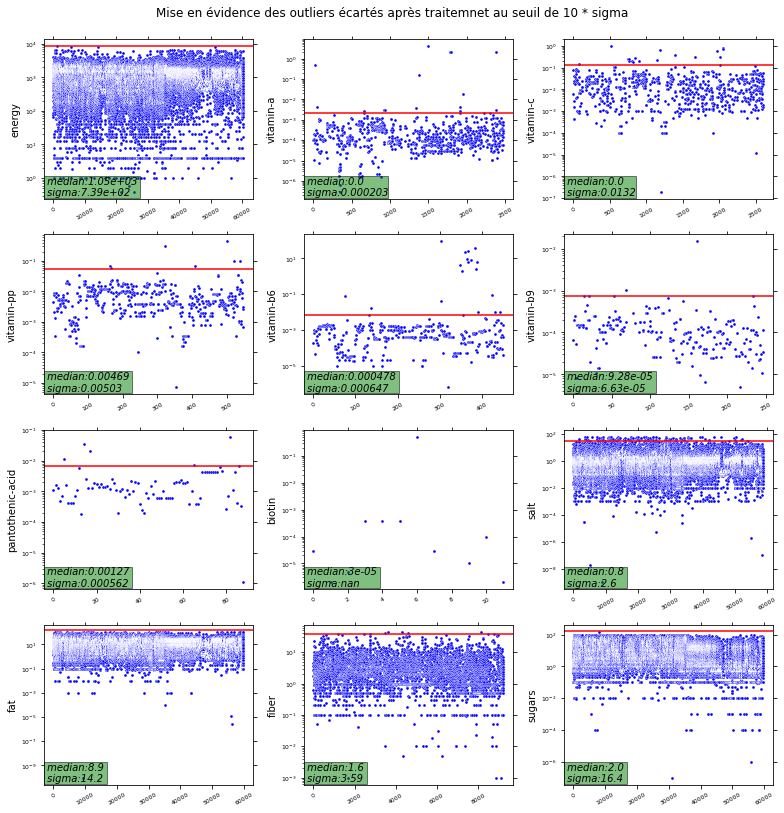

In [91]:
tPlot, axes = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize=(11,11))
axes = np.array(axes)
sigma_factor = 10
i=0
for ax in axes.reshape(-1):
    colonne = quantite[i]
    test = data[pd.notnull(data[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=6)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 10)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=mediane[i] + sigma_factor*sigma[i], color='r', linestyle='-')
    
    ax.text(0., 0.02, ' median:{:.3} \n sigma:{:.3}'.format(mediane[i], sigma[i]),
            style='italic', transform=ax.transAxes, fontsize = 10,
            bbox={'facecolor':'green', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, "Mise en évidence des outliers écartés après traitemnet au seuil de " + str(sigma_factor) + " * sigma", ha='center', fontsize = 12)
plt.tight_layout()

<b  style="background-color:tomato;font-size:14px;">7. IMPUTATIONS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.1. HIGH DENSITY FEATURES<b>
    <a id="load"></a>  

In [92]:
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None
import math

"""
knn imputation function 
"""
def knn_imputation(df_knn,nn):
    
    imputer = KNNImputer(n_neighbors=nn, weights='uniform', metric='nan_euclidean')
    
    #print(df_knn)
    
    df_filled = imputer.fit_transform(df_knn)
    #print(type(df_filled))
    #print('---------------------')
    #print(df_filled[:,1])
    #print('---------------------')
    return df_filled[:,1]

"""
mean imputation function 
"""
def mean_imputation(df,feature):
    #print('mean imputation')
    #print('feature = ' + feature)
    #print(df.head())
    df_feature_mean = df[feature].mean()
    df.loc[(df[feature].isnull()),feature]=df_feature_mean

    #print('---------------------')
    #print(df[feature])
    #print('---------------------')
    
    return df[feature]

"""
add value labels to bar plot function 
"""
def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{:.1f}".format(y_value)

        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      

"""
imputation algorithm 
"""
def imputation(data,features,type):
    mean_updates=pd.DataFrame()
    mean_dict={"feature":[],"original_mean":[],"original_std":[],"new_mean":[],"new_std":[]}
    
    cpt_feature=0
    for feature in features.index:
        #print('******* ' + feature)    
        subset = data[['categories_tags',feature]]

        #valuate mean and standard deviation before knn algorithm
        feature_mean = subset[feature].mean()
        feature_std = subset[feature].std()
        feature_mean_new = feature_mean
        feature_std_new = feature_std
        #print('    - mean = ' + str(feature_mean))
        #print('    - std = ' + str(feature_std))

        subset = subset[subset["categories_tags"].notna()]
        #print(subset.head())

        i=[]
        for k in range(subset.shape[0]):
            i.append(0)
        #add dummy column as knn only works at least 2 numerical columns subsets     
        subset['dummy']=i
        cpt_categ=0
        for col in subset['categories_tags'].unique():
            #print('* ' + col)
            subset_cat=subset.loc[data['categories_tags'] == col]
            #print(str(len(subset_cat)))
            #print(subset_cat)

            #We don't try imputation if category does not have a single valuated row or if category does not have any nan
            feature_categ_mean = subset_cat[feature].mean()
            if (not math.isnan(feature_categ_mean)) and subset_cat[feature].isnull().values.any():
                subset_imputation=subset_cat[['dummy',feature]]
                if type == "knn":
                    new_values = knn_imputation(subset_imputation,3)
                if type == "mean":
                    new_values = mean_imputation(subset_imputation,feature)
                subset_cat['newvalues']=new_values
                #print(subset_cat)

                #Identify row index where values has been changed. Update with imputed value in the dataframe.
                #print('changed indexes')
                #print('---------------')
                changed_values=subset_cat.loc[(subset_cat[feature] != subset_cat['newvalues'])]
                #print(changed_values)
                for d in changed_values.index:
                    #print('**** '+ str(d) + ' ---> ' + str(changed_values.at[d,'newvalues']))
                    data.at[d, feature] = changed_values.at[d,'newvalues']
            cpt_categ = cpt_categ +1
            if cpt_categ == 15:
                break
            
        subset = data[['categories_tags',feature]]
        feature_mean_new = subset[feature].mean()
        feature_std_new = subset[feature].std()
        #print('    - mean = ' + str(feature_mean_new))
        #print('    - std = ' + str(feature_std_new))

        mean_dict["feature"].append(feature)
        mean_dict["original_mean"].append(feature_mean)
        mean_dict["original_std"].append(feature_std)
        mean_dict["new_mean"].append(feature_mean_new)
        mean_dict["new_std"].append(feature_std_new)
        
        cpt_feature = cpt_feature +1
        if cpt_feature == 3:
            break            

    mean_updates=pd.DataFrame.from_dict(mean_dict)
    print(mean_updates)
    type="knn"
    plt.figure(figsize=(20,5))

    fig, axes = plt.subplots(4,3, figsize=(16,8))

    plt.suptitle("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées (12 premières features)")
    for i, ax in zip(range(12), axes.flat):
        try:
            ax1=ax
            x=['original','imputation']
            ax1.set_xlabel(['original','imputation'])
            ax1.set_ylabel('mean', color='blue')
            ax1.bar(x, [mean_dict['original_mean'][i],mean_dict['new_mean'][i]], color='blue')
            ax1.tick_params(axis='y', labelcolor="blue")
            add_value_labels(ax1)

            ax2 = ax1.twinx()  

            ax2.set_ylabel('std', color="red") 
            ax2.plot(x, [mean_dict['original_std'][i],mean_dict['new_std'][i]], color='red')
            ax2.tick_params(axis='y', labelcolor='red')    

            ax.set_title(mean_dict['feature'][i])
        except:
            break
            
    plt.tight_layout()    

    plt.show() 

    try:
        del subset
        del subset_imputation
        del subset_cat
        del mean_updates
    except:
        k=0
    
    return data

Empty DataFrame
Columns: [feature, original_mean, original_std, new_mean, new_std]
Index: []


<Figure size 1440x360 with 0 Axes>

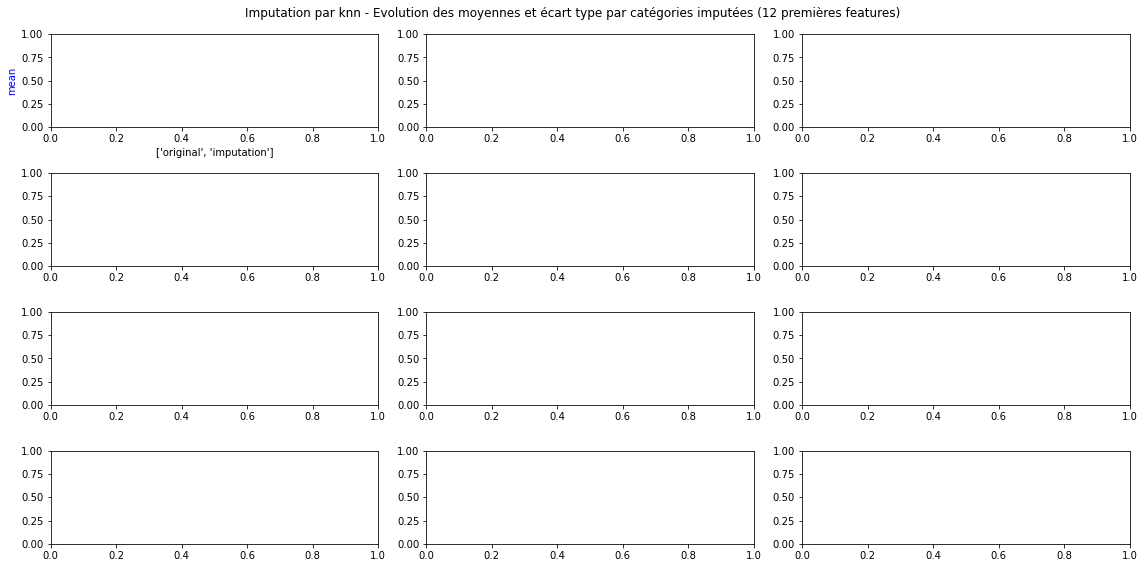

In [93]:
to_be_completed = percent_of_nans[(percent_of_nans < 25) & (percent_of_nans > 0)]
to_be_completed_high_density = to_be_completed.filter(like='_100g')
data=imputation(data,to_be_completed_high_density,'knn')

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.2. MID DENSITY FEATURES<b>
    <a id="load"></a>  

            feature  original_mean  original_std    new_mean     new_std
0       sodium_100g       0.536882      1.131881    0.535805    1.128801
1         salt_100g       1.341809      2.824779    1.339120    2.817094
2  energy-kcal_100g     265.302145    178.739110  264.925370  178.331856


<Figure size 1440x360 with 0 Axes>

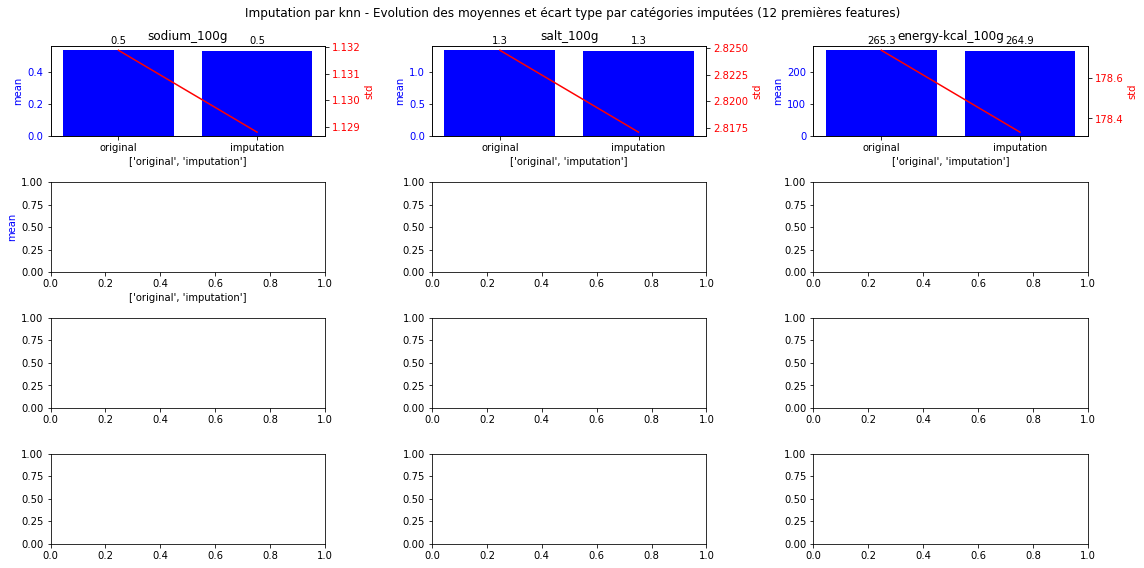

In [94]:
to_be_completed = percent_of_nans[(percent_of_nans < 50) & (percent_of_nans >= 25 )]
to_be_completed_average_density = to_be_completed.filter(like='_100g')
data=imputation(data,to_be_completed_average_density,'mean')

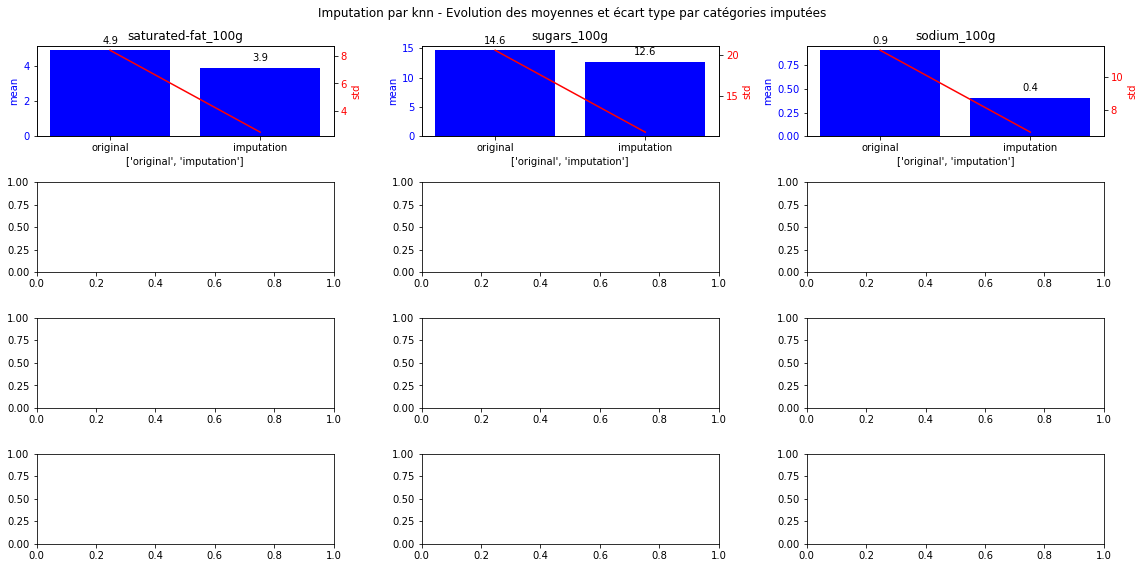

In [14]:
mean_dict = {'feature': ['saturated-fat_100g', 'sugars_100g', 'sodium_100g'], 
               'original_mean': [4.879271548407266, 14.598996855139022, 0.9048227394409329], 
               'original_std': [8.431585286234403, 20.58031162590478, 11.618527866948243], 
               'new_mean': [3.879271548407266, 12.598996855139022, 0.4048227394409329], 
               'new_std': [2.431585286234403, 10.58031162590478, 6.618527866948243]}
mean_updates=pd.DataFrame.from_dict(mean_dict)
#print(mean_updates)
type="knn"
#plt.figure(figsize=(20,5))

#fig, axes = plt.subplots(3, 1, figsize=(16,8))
#axes = np.array(axes)
#fig, (ax1, ax2) = plt.subplots(3, 2, figsize=(16,8))
fig, axes = plt.subplots(4,3, figsize=(16,8))

plt.suptitle("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées")
for i, ax in zip(range(3), axes.flat):
#for i in range(3):
    #ax1, ax1a = two_scales(ax1, t, s1, s2, 'r', 'b')
    #ax2, ax2a = two_scales(ax2, t, s1, s2, 'gold', 'limegreen')
    ax1=ax
    x=['original','imputation']
    ax1.set_xlabel(['original','imputation'])
    ax1.set_ylabel('mean', color='blue')
    ax1.bar(x, [mean_dict['original_mean'][i],mean_dict['new_mean'][i]], color='blue')
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('std', color="red")  # we already handled the x-label with ax1
    ax2.plot(x, [mean_dict['original_std'][i],mean_dict['new_std'][i]], color='red')
    ax2.tick_params(axis='y', labelcolor='red')    

    add_value_labels(ax1)
    
    #sns.lineplot(ax=ax, x=['original','imputation'], y=[mean_dict['original_mean'][i],mean_dict['new_mean'][i]],color='red',label="mean")
    #sns.lineplot(ax=ax2, x=['original','imputation'], y=[mean_dict['original_std'][i],mean_dict['new_std'][i]],color='green',label="std")
    #color_y_axis(ax,'red')
    
    ax.set_title(mean_dict['feature'][i])
    #ax.legend(loc="upper right")
    #color_y_axis(ax1, 'r')
    #color_y_axis(ax1a, 'b')
    #color_y_axis(ax2, 'gold')
    #color_y_axis(ax2a, 'limegreen')

plt.tight_layout()    
    
plt.show()

